In [1]:
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import torch
from functools import partial
import json
import rasterio
import fiona
from rasterio.mask import mask
from torchvision import datasets

In [2]:
result_file = Path("../reports/results_mul_pansharpen.pkl")

with open(result_file, 'rb') as file:
    results = pickle.load(file)
    
results.keys()

dict_keys(['train', 'val'])

In [3]:
def iou(cm: np.ndarray) -> float:
    return cm[-1, -1] / (cm.sum() - cm[0, 0])


def plot_iou(results: dict, fig_folder: Path) -> None:
    """Shows the evolution of the intersection over union ratio.
    The results are saved in a .png file.

    Args:
        results (dict): a dictionary containing the results
        fig_folder (Path): the folder where vizualisations are saved
    """
    fig_folder.mkdir(exist_ok=True)
    cm_epoch_val = results["val"]["conf_matrix"]
    corr_pred_val = np.array([iou(cm) for cm in cm_epoch_val])
    
    cm_epoch_train = results["train"]["conf_matrix"]
    corr_pred_train = np.array([iou(cm) for cm in cm_epoch_train])

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(corr_pred_train, label="Train")
    ax.plot(corr_pred_val, label="Val")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("IoU")
    ax.set_title("Evolution of IoU")
    ax.legend()
    fig.savefig(fig_folder / "iou.png")

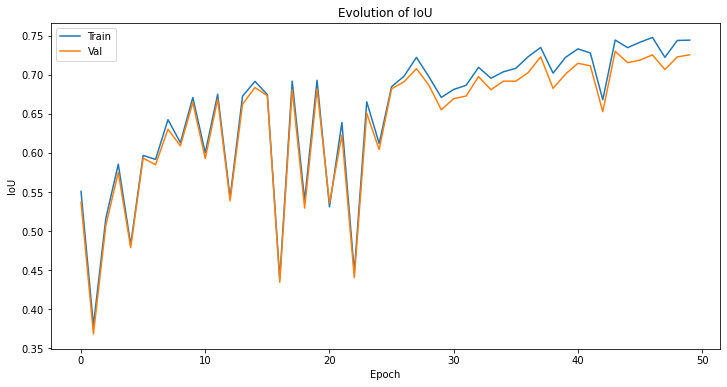

In [4]:
fig_folder = Path('../reports/figures')

plot_iou(results, fig_folder)

In [5]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=8, out_channels=2, init_features=32, pretrained=False)

model_path = Path("../models/unet_model")

model.load_state_dict(torch.load(model_path))
model.eval()

Using cache found in /home/jupyter/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


UNet(
  (encoder1): Sequential(
    (enc1conv1): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu1): ReLU(inplace=True)
    (enc1conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc1norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc1relu2): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (enc2conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (enc2relu1): ReLU(inplace=True)
    (enc2conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (enc2norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [31]:
def norm_img(img, mean_arr, std_arr):
    res = (np.transpose(img, (1, 2, 0)) - mean_arr) / std_arr
    return np.transpose(res, (2, 0, 1))


def add_padding(arr, pad_h, pad_w):
    n_ch, h, w = arr.shape
    
    plus_h = np.zeros((n_ch, pad_h, w))
    plus_w = np.zeros((n_ch, h+pad_h, pad_w))
    
    temp = np.concatenate((arr, plus_h), axis=1)
    return np.concatenate((temp, plus_w), axis=2)

def load_tif(fn, df, mean_vec, std_vec, building_folder, padding=None):
    img_id = "_".join(Path(fn).stem.split("_")[1:])  # get img id

    no_building = df[df['BuildingId'] == -1]['ImageId'].unique().tolist()
    geojson_path = building_folder / f"buildings_{img_id}.geojson"

    # Extract the file as a (8 x 650 x 650) cube
    with rasterio.open(fn) as tif:
        arr = tif.read()
        info = tif.meta
    
    info['count'] = 1
    # Extract geofeatures if the image has buildings
    if img_id in no_building:
        X = np.zeros((info['height'], info['width']), dtype='uint16')
        features = []
    else:
        with fiona.open(geojson_path, "r") as geojson:
            features = [feature["geometry"] for feature in geojson]
        X = np.ones((info['height'], info['width']), dtype='uint16')

    # Write polygons as a tif whose dimensions are the same than the opened tif
    with rasterio.open('temp.tif', 'w', **info) as new_ds:
        new_ds.write(X, 1)
    
    # Extract mask if necessary
    with rasterio.open('temp.tif') as tif:
        if features:
            mask_img, _ = mask(tif, features)
        else:
            mask_img = tif.read()
    
    if padding:
        pad_h, pad_w = padding
        arr = add_padding(arr,pad_h, pad_w )
        mask_img = add_padding(mask_img,pad_h, pad_w )
    
#     arr = norm_img(arr, mean_vec, std_vec)
    arr, mask_img = arr.astype('float32'), mask_img.squeeze().astype('int64')
    Path('temp.tif').unlink()

    return arr, mask_img

In [32]:
n_ch=8
h = 650
w = 650

df = pd.read_csv('../data/processed/train/Building_Solutions.csv')
with open('../data/processed/stats_mul_pan.json') as file:
    stats = json.load(file)
    
mean_channels = stats["mean"]
std_channels = stats["std"]

building_folder = Path('../data/processed/train/buildings')

pad_h, pad_w = 8 - h % 8, 8 - w % 8

load_tif_with_mask = partial(
        load_tif,
        df=df,
        mean_vec=mean_channels,
        std_vec=std_channels,
        building_folder=building_folder,
        padding=(pad_h, pad_w))

In [52]:
image_folder = Path('../data/processed/train/data/MUL-PanSharpen')

ds = datasets.DatasetFolder(root=image_folder,
                                loader=load_tif_with_mask,
                                extensions=('.tif',))

In [53]:
(img, mask_img), _ = ds[8]
img.shape, mask_img.shape

((8, 656, 656), (656, 656))

In [54]:
fig_folder = Path('../reports/figures')

n_imgs = 6

In [55]:
random_idx = np.random.choice(len(ds), size=10)

imgs = []
masks = []

for i in random_idx:
    (img, mask_img), _ = ds[i]
    imgs.append(torch.from_numpy(img))
    masks.append(torch.from_numpy(mask_img))
    
imgs, masks = torch.stack(imgs), torch.stack(masks)

imgs.shape, masks.shape

(torch.Size([10, 8, 656, 656]), torch.Size([10, 656, 656]))

In [56]:
with torch.no_grad():
    pred = model(imgs)
    
pred.shape

torch.Size([10, 2, 656, 656])

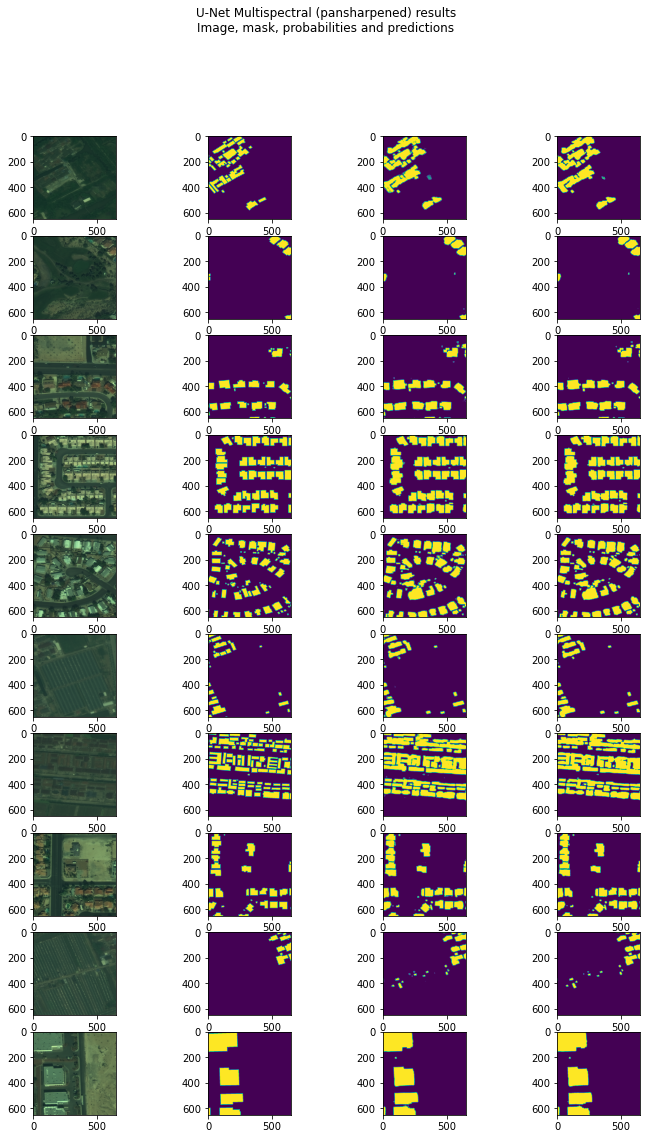

In [60]:
n_rows = pred.shape[0]
n_cols = 4

fig, axs = plt.subplots(n_rows, n_cols, figsize=(12,18))
fig.suptitle('U-Net Multispectral (pansharpened) results\nImage, mask, probabilities and predictions', fontsize=12)

for i_row, axrow in enumerate(axs):
    img_rgb = imgs[i_row, [4, 2, 1], :650, :650].numpy()
    img_rgb = np.transpose(img_rgb, axes=(1, 2, 0))
    img_rgb = (img_rgb - img_rgb.min()) / (img_rgb.max() - img_rgb.min())
    
    axrow[0].imshow(img_rgb)
    axrow[1].imshow(masks[i_row, :650, :650].numpy())
    axrow[2].imshow(pred[i_row, 1, :650, :650].numpy())
    axrow[3].imshow(pred.argmax(dim=1)[i_row, :650, :650].numpy())
    
fig.savefig(fig_folder / f"mulpansharpen_results_{n_imgs}.png")
    


In [58]:
test_folder = Path('../data/processed/test/MUL-PanSharpen')

n_img = len(list(test_folder.iterdir()))
n_img

3526

In [59]:
n_imgs=2
rand_idx = np.random.choice(n_img, size=5)

def prepare_img(fn, mean_ds, std_ds, padding=None, as_torch=False):
    with rasterio.open(fn) as ds:
        arr = ds.read()
    
    if padding:
        pad_h, pad_w = padding
        arr = add_padding(arr,pad_h, pad_w )
        
    return torch.from_numpy(arr.astype('float32')) if as_torch else arr.astype('float32')

test_imgs = [prepare_img(list(test_folder.iterdir())[i], mean_channels, std_channels,(6,6), as_torch=True) for i in rand_idx]
test_imgs = torch.stack(test_imgs)
test_imgs.shape


torch.Size([5, 8, 656, 656])

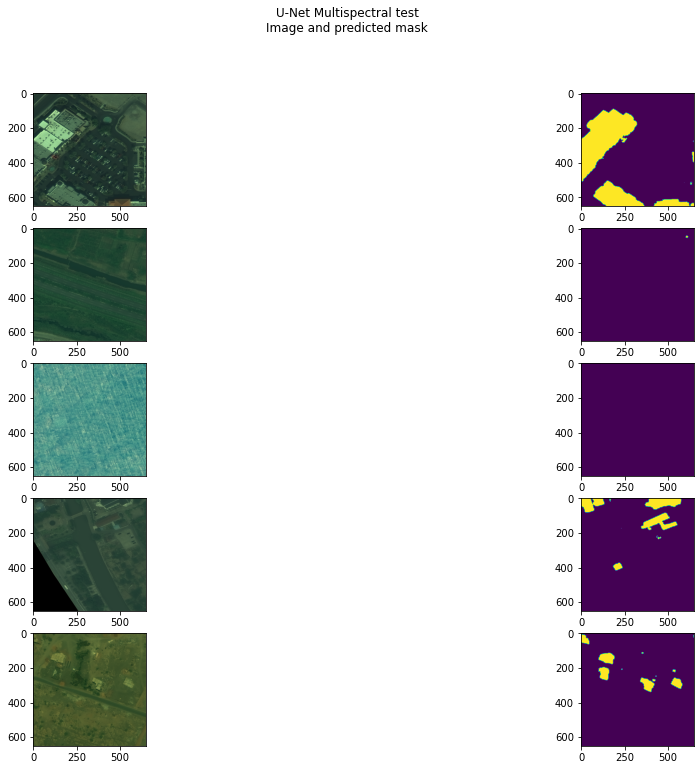

In [45]:
n_rows = test_imgs.shape[0]
n_cols = 2


with torch.no_grad():
    test_pred = model(test_imgs)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(18,12))
fig.suptitle('U-Net Multispectral test\nImage and predicted mask', fontsize=12)

for i_row, axrow in enumerate(axs):
    img_rgb = test_imgs[i_row, [4, 2, 1], :650, :650].numpy()
    img_rgb = np.transpose(img_rgb, axes=(1, 2, 0))
    img_rgb = (img_rgb - img_rgb.min()) / (img_rgb.max() - img_rgb.min())
    
    axrow[0].imshow(img_rgb)
    axrow[1].imshow(test_pred.argmax(dim=1)[i_row, :650, :650].numpy())
    
fig.savefig(fig_folder / f"mulpansharpen_test_{n_imgs}.png")

In [51]:
test_imgs[0].squeeze(0)

with torch.no_grad():
    test_pred_one = model(test_imgs[0].squeeze(0).unsqueeze(0))
    
test_pred_one.squeeze(0).argmax(dim=0).shape

torch.Size([656, 656])